### **Single-cell RNA Sequencing analysis project** ###

This notebook is the outcome of a personal challenge I undertook to master the analysis of single-cell RNA sequencing (scRNAseq).

For this purpose, I decided to replicate a research paper published in Nature (https://www.nature.com/articles/s41586-021-03569-1). 

The study investigated lung cells from multiple COVID-19 patients who succumbed to the disease, with the aim of constructing a comprehensive cellular atlas.

As a native Python programmer, I chose to utilize the Scanpy package for the task. While Scanpy may be relatively new and less widespread compared to its R counterpart, Seurat, its community is rapidly expanding. 

Moreover, Scanpy seamlessly integrates with various multiomics study packages in Python, such as Squidpy for spatial transcriptomics.

But, the most significant advantage of Scanpy - it's in Pyhton =)!

This project is an ongoing endeavor, and I welcome any questions, tips, critiques, or suggestions that could help me enhance my skills.

Yatir
June 8, 2023

In [37]:
import os 
import collections
import numpy as np
import scanpy as sc
import pandas as pd 
import seaborn as sns
from scipy import stats
sc.settings.verbosity = 3
from scipy.sparse import csc_matrix
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
plt.rcParams['font.size'] = 7
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

In [38]:
resume_work = True
dir = r'C:\Users\DuduB21\OneDrive\code\single_cell_analysis\GSE171524_RAW'

**Ribososmal genes**

In [39]:
ribo_gene_df = pd.read_csv(r'https://www.gsea-msigdb.org/gsea/msigdb/human/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=TSV', sep='\t')
ribo_gene_df = ribo_gene_df[ribo_gene_df.STANDARD_NAME=='GENE_SYMBOLS']
ribo_gene_names = ribo_gene_df.loc[:, 'KEGG_RIBOSOME'].values[0].split(',')

**Human cell markers**

In [40]:
human_cell_mrkrs = pd.read_excel(r'C:/Users/DuduB21/OneDrive/code/single_cell_analysis/Cell_marker_Human.xlsx')
lung_mrkrs = human_cell_mrkrs[human_cell_mrkrs.tissue_type=='Lung']
lung_mrkrs.drop(columns=['species', 'tissue_class', 'cell_type', 'cancer_type', 'journal', 'year', 'Title'], inplace=True)

C:\Users\DuduB21\AppData\Local\Temp\ipykernel_6692\2825809026.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lung_mrkrs.drop(columns=['species', 'tissue_class', 'cell_type', 'cancer_type', 'journal', 'year', 'Title'], inplace=True)


**Preproccessing**

In [41]:
def preprocessing(sample_path):

    adata = sc.read_csv(sample_path)
    adata = adata.T
    adata.X = csc_matrix(adata.X)
    adata.obs['sample'] = os.path.basename(sample_path).split('_')[1]
    sc.pp.filter_cells(adata, min_genes=300)

    adata.var['mito'] = adata.var.index.str.startswith(('MT-', 'mt-', 'Mt-'))
    adata.var['ribo'] = adata.var.index.isin(ribo_gene_names)
    sc.pp.calculate_qc_metrics(adata,
                               expr_type='counts', # default value
                               var_type='genes', # default value
                               qc_vars=['mito', 'ribo'],
                               percent_top=None, 
                               log1p=False, 
                               inplace=True)

    upper_limit = np.quantile(adata.obs.n_genes_by_counts, 0.98)
    adata = adata[adata.obs.n_genes_by_counts < upper_limit, :]
    adata = adata[adata.obs.pct_counts_mito < 10, :] # initialy it was 20%. but following the methods in the paper it was reduced to 10% (16.05.23). 
    adata = adata[adata.obs.pct_counts_ribo < 2, :]
    return adata

if not resume_work:
    adata_list = [preprocessing(os.path.join(dir, sample_file)) for sample_file in os.listdir(dir)]

In [42]:
if resume_work:
    adata = sc.read_h5ad(os.path.join(dir, 'combined_samples.h5ad'))

else:
    adata = sc.concat(adata_list)
    adata.write_h5ad(os.path.join(dir, 'combined_samples.h5ad'))

adata.obs['covid'] = adata.obs.loc[:, 'sample'].apply(lambda sample:'Covid-19' if 'cov' in sample else 'Control')
adata

AnnData object with n_obs × n_vars = 108489 × 34546
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'covid'

In [43]:
sc.pp.filter_genes(adata, min_cells=10)
adata.layers['count'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
adata

filtered out 4974 genes that are detected in less than 10 cells
normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 108489 × 29572
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'covid'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'count'

In [44]:
sc.pp.highly_variable_genes(adata, 
                            # n_top_genes=2000, # initialy it was 3,000. but following the methods in the paper it was reduced to 2,000 (16.05.23). 
                            n_top_genes=3000, # initialy it was 3,000. but following the methods in the paper it was reduced to 2,000 (16.05.23). 
                            flavor='seurat',
                            subset=True, # this line neglects this line -> adata = adata[:, adata.var.highly_variable] 
                            batch_key='sample')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:11)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [45]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=.99, key_added='leiden') # -> 23 clusters 
adata.write(os.path.join(dir, 'integrated_samples.h5ad'))

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:05)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:18)
running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:23)


c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


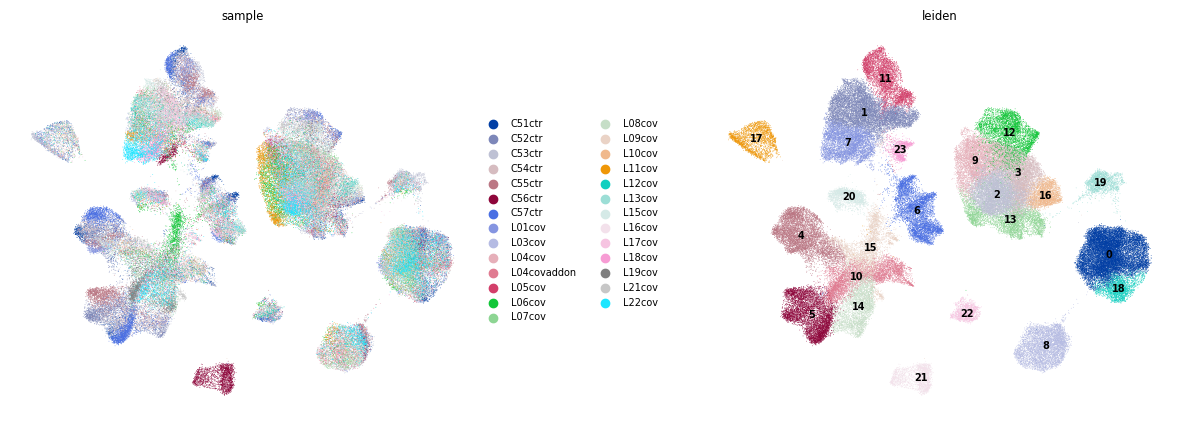

In [46]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.5)
sc.pl.umap(adata, color=['sample'], frameon=False, ax=ax1, show=False)
sc.pl.umap(adata, color=['leiden'], frameon=False, legend_loc='on data', ax=ax2, show=False)
plt.show()

In [47]:
sc.settings.verbosity = 2
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
markers = sc.get.rank_genes_groups_df(adata, group=None, pval_cutoff=0.05, log2fc_min=0.25)
markers

ranking genes
    finished (0:06:28)


c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\tools\_ran

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,PTPRC,135.832718,4.253836,0.000000,0.000000
1,0,SKAP1,124.667282,6.092566,0.000000,0.000000
2,0,PARP8,124.468445,4.185453,0.000000,0.000000
3,0,FYN,122.487190,4.486891,0.000000,0.000000
4,0,ARHGAP15,120.712570,3.890282,0.000000,0.000000
...,...,...,...,...,...,...
48814,23,ANO1,2.990508,2.582112,0.002785,0.045031
48815,23,MLLT3,2.988669,0.544781,0.002802,0.045229
48816,23,TBL1X,2.973036,0.517872,0.002949,0.047160
48817,23,ABI2,2.967900,0.714754,0.002998,0.047903


##### Sources for cell type annotation:
- https://panglaodb.se/index.html
- https://www.cellsignal.com/pathways/immune-cell-markers-mouse
- Data from CellMarker that was introdcued here as mrkrs_df (lung_mrkrs)
- https://www.nature.com/articles/s41586-020-2922-4

In [48]:
def gene_markers(human_cell_mrkrs):
    markers_prevalence = dict(collections.Counter(human_cell_mrkrs.marker))
    markers_prevalence = dict(collections.OrderedDict(sorted(markers_prevalence.items(), key=lambda x: x[1], reverse=True)))
    print(markers_prevalence)
    return markers_prevalence

mrkrs_df = lung_mrkrs[lung_mrkrs.cell_name.str.contains('neu')]
# mrkrs_df = lung_mrkrs[lung_mrkrs.cell_name=='Trigeminal neurons']
# gene_markers(mrkrs_df)
# set(mrkrs_df.cell_name)

c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


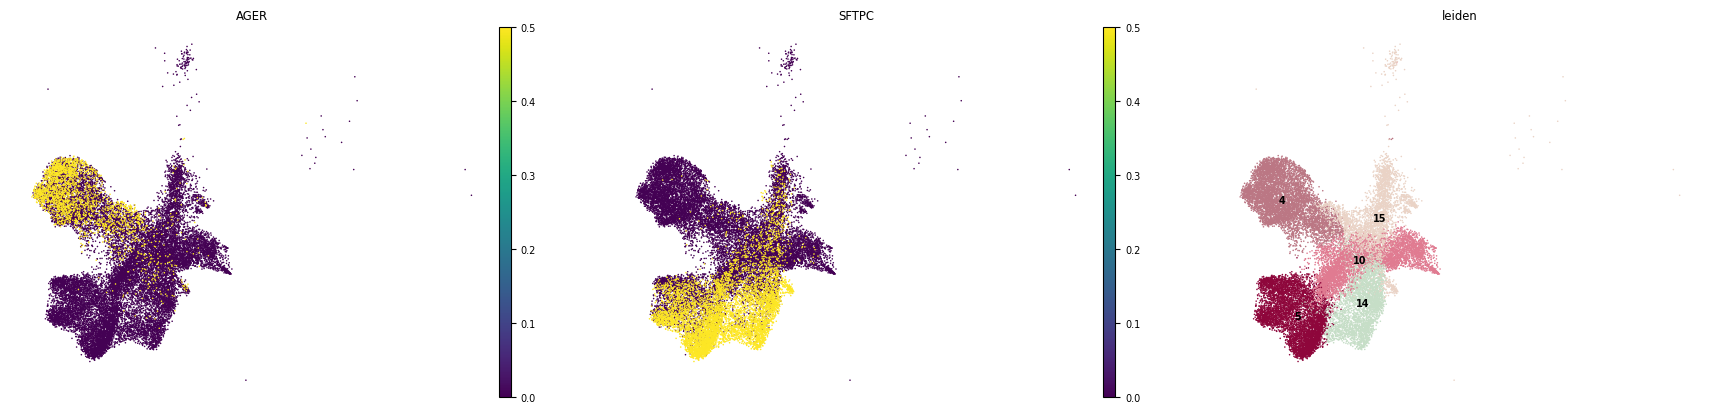

In [49]:
sc.pl.umap(adata[adata.obs.leiden.isin(['4', '5', '10', '14', '15'])], color=['AGER', 'SFTPC', 'leiden'], frameon=False, legend_loc='on data', vmax=.5)
# sc.pl.umap(adata, color=['TAGLN', 'leiden', 'cell_type'] , frameon=False, legend_loc='on data', vmax=.5)
# markers[markers.names=='TAGLN'].sort_values('logfoldchanges', ascending=False)
# markers[markers.group=='10'].sort_values('logfoldchanges', ascending=False).head(25)

In [50]:
# for .99 resolution :
cluster_cell_types = \
                   {0:'T cells', # 'PTPRC' (CD45) which is marker for Immune cells in generarl -> 'CD3E' which is marker for T cells -> 'CD4' for CD4+ (upper part) / 'CD8A' cd8+ (lowerpart) - could be seperated later.
                    1:'LipF/\nAdvF',
                    2:'Macrophages', # ['CD68', 'MARCO', 'APOE'
                    3:'Macrophages', # ['CD14']
                    4:'AT1', # 'AGER']
                    5:'AT2', # SFTPC
                    6:'Endothelial\ncells', # ['PECAM1', 'VWF']
                    7:'MyoF/\nFibM',
                    8:'Plasma\ncells', # ['MZB1', 'JCHAIN','IGHG1', 'XBP1','leiden']
                    9:'Macrophages', # ['CD14']
                    10:'10', # SFTPC
                    11:'AlvF', # ['GPC3']
                    12:'Macrophages', # ['IKZF2'] maybe Alveolar macrophage
                    13:'Monocytes/DCs', # ['ZBTB46']
                    14:'AT2', # SFTPC 
                    15:'15', # SFTPC
                    16:'Macrophages', # ['CD4']
                    17:'Epithelial\ncells', # ['EPCAM']
                    18:'NK', 
                    19:'B\ncells', # ['PXK', 'CD19']
                    20:'Alveolar\ngoblet',
                    21:'Epithelial\ncells', # ['TAGLN', 'ACTA2']
                    # 21:'Neuronal', 
                    22:'Mast', # ['KIT', 'TPSB2']
                    23:'ASM'} # ['MYH11', 'CNN1', 'ACTG2']

cluster_cell_types = {str(k):v for k,v in cluster_cell_types.items()}
adata.obs['cell_type_rep'] = adata.obs.leiden.map(cluster_cell_types)
adata.obs['cell_type'] = adata.obs.leiden.map({k:v.replace('/\n', '_').replace('\n',' ').replace('/','_') for k,v in cluster_cell_types.items()})
adata.write(os.path.join(dir, 'integrated_samples_annotated.h5ad'))

**Cell type frequencies dataframe making**

In [51]:
count_per_sample_dic = dict(collections.Counter(adata.obs.loc[:, 'sample']))
counts_per_CT_df = adata.obs.groupby(['sample', 'covid', 'cell_type']).count().reset_index().loc[:, ['sample', 'covid', 'cell_type', 'total_counts']]
counts_per_CT_df = counts_per_CT_df[counts_per_CT_df.total_counts > 0]
counts_per_CT_df.rename({'total_counts':'cell_count'}, inplace=True, axis=1)
counts_per_CT_df['sample_cell_count'] = counts_per_CT_df.loc[:, 'sample'].apply(lambda sample:count_per_sample_dic.get(sample))
counts_per_CT_df['sample_cell_count'] = counts_per_CT_df.sample_cell_count.astype(int)
counts_per_CT_df['freq'] = counts_per_CT_df.cell_count/counts_per_CT_df.sample_cell_count

major_diff_dict = \
                   {'B cells':'B/plasma',
                    'Plasma cells':'B/plasma',
                    # 'AlvF':'Fibroblasts',
                    'LipF_AdvF':'Fibroblasts',
                    'MyoF_FibM':'Fibroblasts',
                    'T cells':'T/NK',
                    'NK':'T/NK',
                    # 'Monocytes_DCs':'Myeloid',
                    'Macrophages':'Myeloid',
                    'Endothelial cells':'Endothelium',
                    'Epithelial cells':'Epithelia',
                    'AT1':'Epithelia',
                    'AT2':'Epithelia',
                    # '10':'Epithelia',
                    'Mast':'Mast cells'}
                    # 'Neuronal':'Neuronal'}

counts_per_CT_df['mjr_dfrntion_cell_type'] = counts_per_CT_df.cell_type.apply(lambda cell_type:major_diff_dict.get(cell_type))
counts_per_CT_df = counts_per_CT_df[~(counts_per_CT_df.mjr_dfrntion_cell_type.isna())]
counts_per_CT_df

,sample,covid,cell_type,cell_count,sample_cell_count,freq,mjr_dfrntion_cell_type
3,C51ctr,Control,AT1,822,5948,0.138198,Epithelia
4,C51ctr,Control,AT2,739,5948,0.124243,Epithelia
7,C51ctr,Control,B cells,42,5948,0.007061,B/plasma
8,C51ctr,Control,Endothelial cells,608,5948,0.102219,Endothelium
9,C51ctr,Control,Epithelial cells,268,5948,0.045057,Epithelia
...,...,...,...,...,...,...,...
966,L22cov,Covid-19,Mast,7,6370,0.001099,Mast cells
968,L22cov,Covid-19,MyoF_FibM,1274,6370,0.200000,Fibroblasts
969,L22cov,Covid-19,NK,121,6370,0.018995,T/NK
970,L22cov,Covid-19,Plasma cells,532,6370,0.083516,B/plasma


**general functions for plotting**

In [52]:
def umap_plot_foramt(ax):
    ax.set_title(str())
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)

def color_pallet():
    return {'Control':'#006D81', 
            'Covid-19':'#A90639', 
            'AT1':'#0072B2', 
            'AT2':'#0AB45A',
            'KRT8':'#F84D7B',
            'CLDN4':'#F84D7B',
            'CDKN1A':'#F84D7B',
            'DATP':'#F84D7B'}

def seurat_heatmap_colorbar():
    colors = [(183/255, 0, 235/255), (0, 0, 0), (1, 1, 0)]
    # Define the positions for the colors in the color map
    positions = [0, 0.5, 1]
    # Create the custom color map
    cmap = LinearSegmentedColormap.from_list('seurat_heatmap', list(zip(positions, colors)))
    return cmap

def boxplot_properties(clr, lnw=.85):
    boxprops = dict(linewidth=lnw, edgecolor=clr, facecolor='white')
    medianprops = dict(linewidth=lnw, color=clr)
    whiskerprops = dict(linewidth=lnw, color=clr)
    return boxprops, medianprops, whiskerprops

def format_pvalue(pvalue, thresold=.01):
    if pvalue > thresold:
        pvalue = np.format_float_positional(pvalue, precision=3)
    else:
        pvalue = np.format_float_scientific(pvalue, precision=1, exp_digits=2)
    return pvalue

**Major cell type figures**

c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


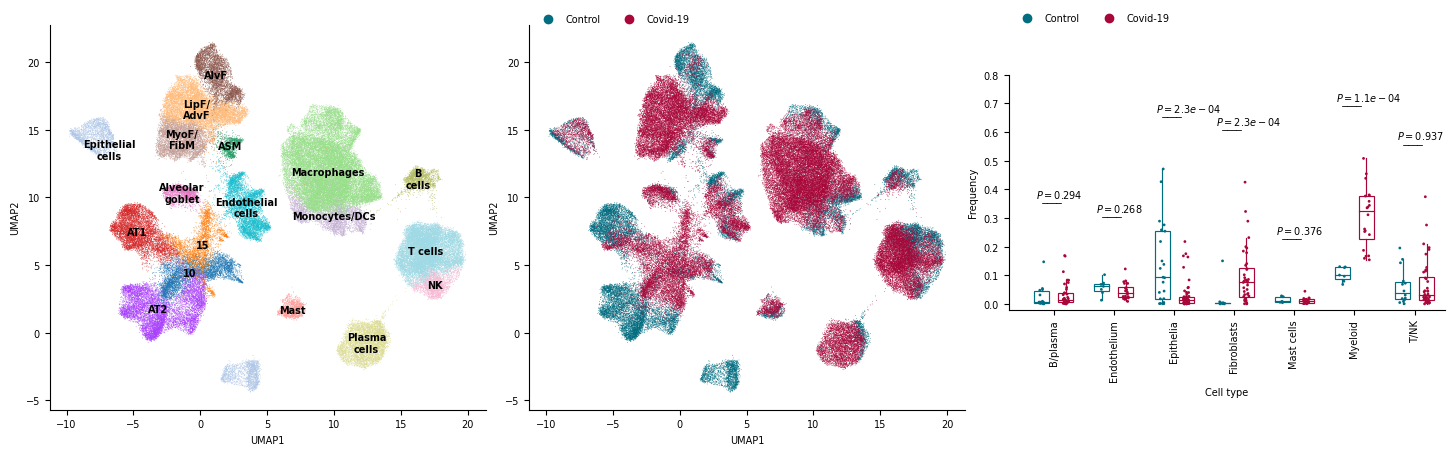

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.1)
left, bottom, width, height = ax3.get_position().bounds
ax3.set_position([left, bottom+.2, width, height-.3])

# adding the umpas :
sc.pl.umap(adata, color=['cell_type_rep'], frameon=True, legend_loc='on data', show=False, ax=ax1)
sc.pl.umap(adata, color=['covid'], frameon=True, legend_loc='right margin', palette={'Covid-19':'#A90639', 'Control':'#006D81'}, show=False, ax=ax2)

# boxplot : 
grouped = counts_per_CT_df.groupby('mjr_dfrntion_cell_type')
cell_types = [group[0] for group in grouped]
controls = [sub_df[sub_df.covid=='Control'].freq for _, sub_df in grouped]
covid = [sub_df[sub_df.covid=='Covid-19'].freq for _, sub_df in grouped]
offset=.2
positions = [(pos - offset, pos + offset) for pos in range(0, len(cell_types))]
ticks_positions = [pos for pos in range(0, len(cell_types))]

pvalues_dict = dict()
for CT, ctrl, cvd in zip(cell_types, controls, covid):
    pvalue = stats.ranksums(ctrl, cvd).pvalue
    pvalue = format_pvalue(pvalue)
    max_values = max(np.concatenate((cvd.to_numpy(), ctrl.to_numpy())))
    pvalues_dict[CT] = (pvalue, max_values)

widths=.25
boxprops, medianprops, whiskerprops = boxplot_properties(color_pallet().get('Control'))
ax3.boxplot(labels=cell_types, 
            x=controls, 
            positions=[pos[0] for pos in positions], 
            widths=widths, 
            patch_artist=True, 
            showcaps=False, 
            showfliers=False, 
            boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)
boxprops, medianprops, whiskerprops = boxplot_properties(color_pallet().get('Covid-19'))
ax3.boxplot(labels=cell_types, 
            x=covid, 
            positions=[pos[1] for pos in positions], 
            widths=widths, 
            patch_artist=True, 
            showcaps=False, 
            showfliers=False, 
            boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)

for (CT, pvalue_max), loc in zip(pvalues_dict.items(), positions):
    ax3.text(x=loc[0]-.1, 
             y=np.clip(a=pvalue_max[1]+.2, a_min=0, a_max=.8), 
             s=f'$P = {pvalue_max[0]}$')
    ax3.text(x=loc[0]-.1, 
             y=np.clip(a=pvalue_max[1]+.2, a_min=0, a_max=.8)-0.005, 
             s='  ____')

ax3.set_xticks(ticks_positions, cell_types, rotation=90)

sns.stripplot(data=counts_per_CT_df,
              x='mjr_dfrntion_cell_type', 
              y='freq', 
              hue='covid', 
              order=cell_types,
              size=2, 
              palette=color_pallet(),
              linewidth=0, 
              dodge=True,
              legend=False,
              ax=ax3,
              jitter=True,
              native_scale=True)

for ax in [ax1, ax2, ax3]:
    ax.set_title(str())
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    if ax in [ax1, ax2]:
        ax.set_xticks(np.arange(-10, 25, 5))
        ax.set_yticks(np.arange(-5, 21, 5))

for ax, loc in zip([ax2, ax3], [(0, 1.05), (0, 1.3)]):
    ax.legend(handles=[Line2D([0], [0], marker='o', color='#006D81', label='Control', linewidth=0),
                        Line2D([0], [0], marker='o', color='#A90639', label='Covid-19', linewidth=0)], 
               loc='upper left', frameon=False, ncols=2, bbox_to_anchor=loc)

ax3.set_ylim(-.02,.8)
ax3.set_xlim(-.75,6.5)
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Cell type')

fig.savefig(os.path.join(r'C:\Users\DuduB21\OneDrive\code\single_cell_analysis\restore_figures', 'first_fig.png'), dpi=300)
plt.show()

### **AT analysis**

In [54]:
AT_adata = adata[adata.obs.cell_type.isin(['AT1', 'AT2'])].copy()
sc.tl.leiden(AT_adata, resolution=.65, key_added='leiden_AT') # -> leading to 9 clusters 
sc.tl.umap(AT_adata, n_components=3)
AT_umap = AT_adata.obsm['X_umap']

DATP_sig_path = r'https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-021-03569-1/MediaObjects/41586_2021_3569_MOESM11_ESM.xlsx'
DATP_sig = pd.read_excel(DATP_sig_path, sheet_name='our_datp_sig').iloc[2:,0].to_list()

sc.tl.score_genes(AT_adata, 
                  gene_list=DATP_sig, 
                  ctrl_size=163, 
                  n_bins=50, 
                  score_name='DATP')

DATP_sig_threshold = 0.4
AT_adata.obs['isDATP'] = AT_adata.obs.loc[:, ['cell_type', 'DATP']].apply(lambda x: 'DATP' if x.DATP > DATP_sig_threshold else x.cell_type, axis=1)

DATP_ratio = AT_adata.obs.copy()
DATP_ratio['isDATP'] = DATP_ratio.isDATP.apply(lambda x:'DATP' if x=='DATP' else 'AT')
DATP_ratio = DATP_ratio.groupby(['sample', 'covid', 'isDATP']).count().reset_index().loc[:, ['sample', 'isDATP', 'total_counts']]
DATP_ratio = DATP_ratio[DATP_ratio.total_counts > 0]
DATP_ratio.rename({'total_counts':'cell_count'}, inplace=True, axis=1)
DATP_ratio = DATP_ratio.pivot(index='sample', columns='isDATP', values='cell_count').reset_index()
DATP_ratio['freq'] = DATP_ratio['DATP'] / DATP_ratio['AT']
DATP_ratio['sample'] = DATP_ratio.loc[:, 'sample'].apply(lambda x:'Control' if 'ctr' in x else 'Covid-19')
DATP_ratio = DATP_ratio.loc[:,['sample', 'freq']]
DATP_ratio.rename({'sample':'covid'}, inplace=True, axis=1)
DATP_ratio = DATP_ratio[DATP_ratio.freq < 1]

running Leiden clustering
    finished (0:00:01)
computing UMAP
    finished (0:00:08)
computing score 'DATP'
    finished (0:00:00)


c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


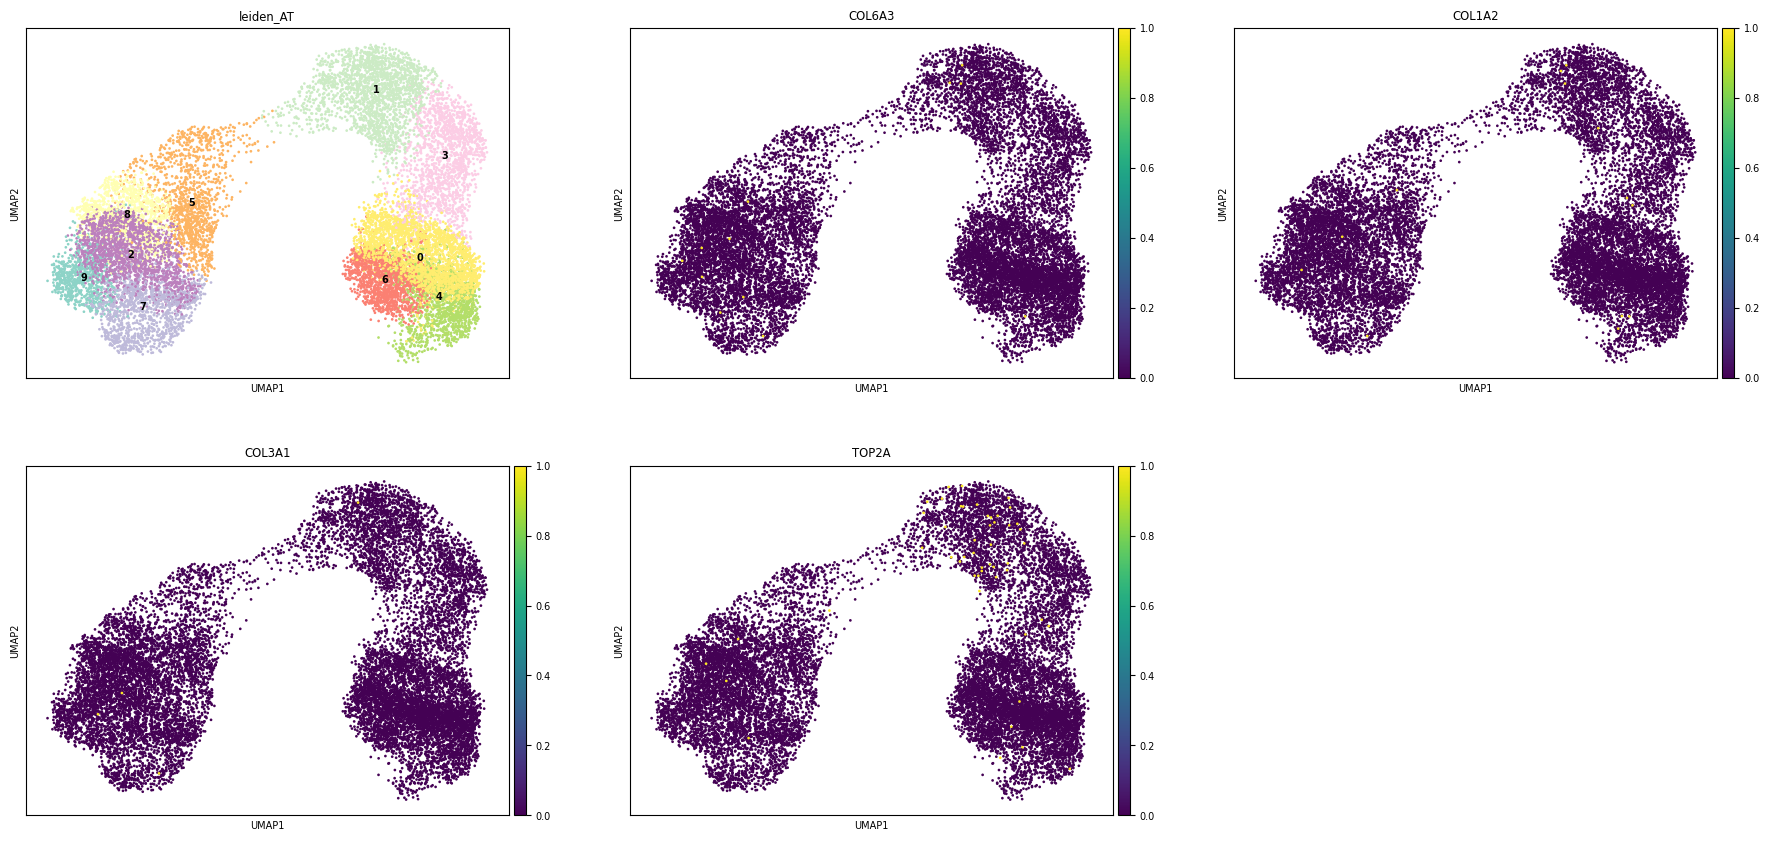

In [55]:
sc.pl.umap(AT_adata, color=['leiden_AT', 'COL6A3', 'COL1A2', 'COL3A1', 'TOP2A'], legend_loc='on data', frameon=True, s=15, alpha=1, palette='Set3_r', ncols=3, vmax=1)

c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


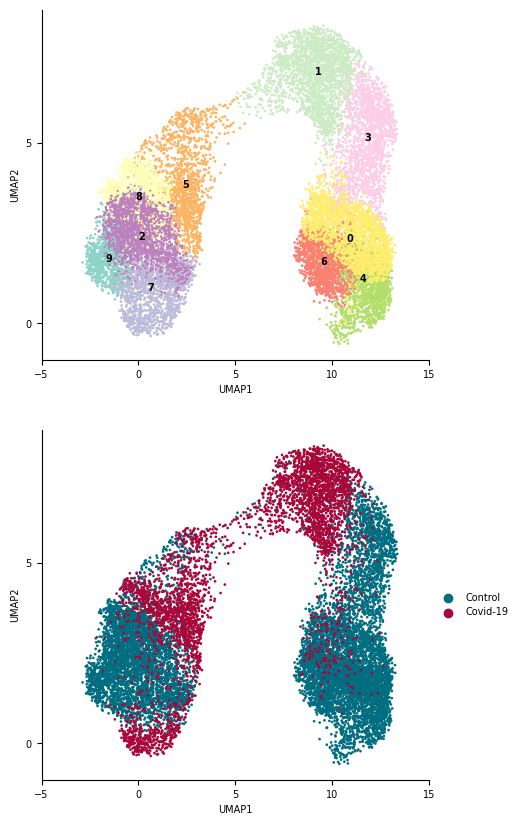

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5,10))
sc.pl.umap(AT_adata, color=['leiden_AT'], legend_loc='on data', frameon=True, s=15, alpha=1, show=False, ax=ax1, palette='Set3_r')#, legend_fontweight='semibold', legend_fontsize=10)
sc.pl.umap(AT_adata, color=['covid'], legend_loc='right margin', frameon=True, s=15, alpha=1, show=False, ax=ax2)
umap_plot_foramt(ax1)
umap_plot_foramt(ax2)
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(-5, 20, 5))
    ax.set_yticks(np.arange(0, 10, 5))
plt.show()

c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


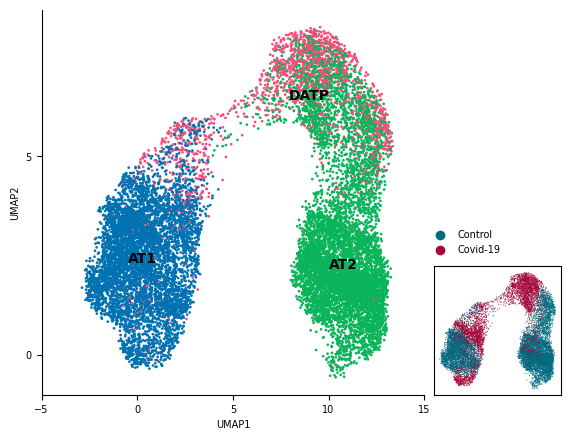

In [57]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.subplots_adjust(wspace=0.025)
left2, bottom2, width2, height2 = ax2.get_position().bounds
ax2.set_position([left2, bottom2, width2/3, height2/3])

sc.pl.umap(AT_adata, 
           frameon=True, 
           legend_loc='on data', 
           show=False, 
           ax=ax1, 
           color=['isDATP'], 
           palette=color_pallet(),
           s=15, 
           alpha=1,
           legend_fontweight='semibold', 
           legend_fontsize=10)

sc.pl.umap(AT_adata, 
           frameon=True, 
           show=False, 
           ax=ax2,
           color=['covid'], 
           palette=color_pallet(), 
           size=2)

for ax in [ax1, ax2]:
    ax.set_title(str())

for side in ['right', 'top']:
    ax1.spines[side].set_visible(False)

ax2.set(xlabel=None, ylabel=None)
ax2.legend(handles=[Line2D([0], [0], marker='o', color='#006D81', label='Control', linewidth=0),
                    Line2D([0], [0], marker='o', color='#A90639', label='Covid-19', linewidth=0)], 
           loc='upper center', frameon=False, ncols=1, bbox_to_anchor=(.25, 1.35, 0, 0))

ax1.set_xticks(np.arange(-5, 20, 5))
ax1.set_yticks(np.arange(0, 10, 5))

# fig.savefig(os.path.join(r'C:\Users\DuduB21\OneDrive\code\single_cell_analysis\restore_figures', 'AT_cells_2d.png'), dpi=300)
plt.show()

C:\Users\DuduB21\AppData\Local\Temp\ipykernel_6692\1485377730.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(sm,


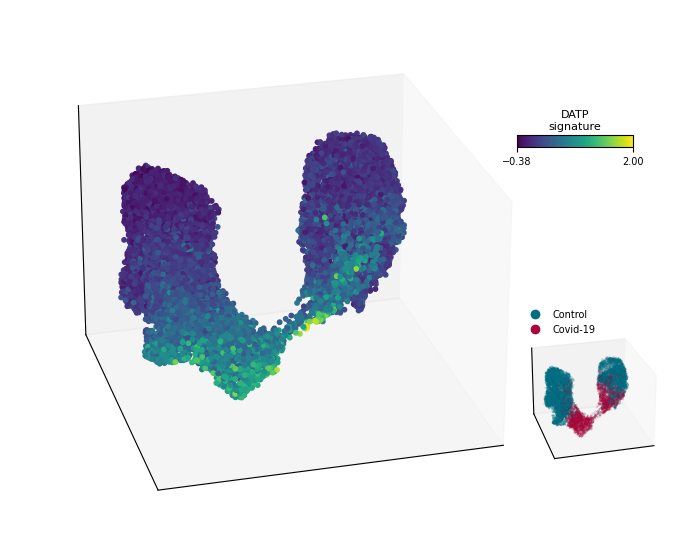

In [58]:
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax2 = fig.add_subplot(2, 3, 6, projection='3d')

plt.subplots_adjust(wspace=1)

sm = ScalarMappable(cmap='viridis', 
                    norm=mpl.colors.Normalize(vmin=-.38, vmax=2))
sm.set_array(AT_adata.obs.DATP)

ax1.scatter(xs=AT_umap[:,0], 
            ys=AT_umap[:,1], 
            zs=AT_umap[:,2],
            c=AT_adata.obs.DATP,
            # c=AT_adata.obs.isDATP.map(color_pallet()),
            cmap='viridis',
            s=10,
            alpha=1)

cb = plt.colorbar(sm, 
                  orientation='horizontal', 
                  aspect=10,
                  shrink=.75, 
                  anchor=(.125,16),
                  ticks=[-0.38, 2])

cb.ax.xaxis.set_label_position('top')
cb.set_label('DATP\nsignature', fontdict={'size': '8'})

ax2.scatter(xs=AT_umap[:,0], 
            ys=AT_umap[:,1], 
            zs=AT_umap[:,2],
            c=AT_adata.obs.covid.map(color_pallet()),
            s=1e-2,
            alpha=1)

for ax in [ax1, ax2]:
    ax.set_title(str())

for side in ['right', 'top']:
    ax1.spines[side].set_visible(False)

ax2.set(xlabel=None, ylabel=None)
ax2.legend(handles=[Line2D([0], [0], marker='o', color='#006D81', label='Control', linewidth=0),
                Line2D([0], [0], marker='o', color='#A90639', label='Covid-19', linewidth=0)], 
           loc='upper center', frameon=False, ncols=1, bbox_to_anchor=(.3125, 1.125, 0, 0))

ax1.set_xticks(np.arange(-4, 0, 5))
ax1.set_yticks(np.arange(0, 11, 5))

for side in ['right', 'top', 'left', 'bottom']:
    ax2.spines[side].set_visible(False)

for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks(list())
    ax.set_yticks(list())
    ax.set_zticks(list())
    ax.view_init(elev=25, 
              azim=75,
              roll=0)
# fig.savefig(os.path.join(r'C:\Users\DuduB21\OneDrive\code\single_cell_analysis\restore_figures', 'AT_cells_3d.png'), dpi=300)
plt.show()

In [59]:
def create_violin(adata, 
                  ax, 
                  keys,
                  value_type,
                  grpby='covid',
                  pvalue=True,
                  pvalue_undrln=True,
                  xlabel=None,
                  ylabel=None,
                  linewidth=0.75):
    
    sc.pl.violin(adata, 
             keys=keys, 
             groupby=grpby, 
             show=False, 
             multi_panel=True,
             ax=ax, 
             stripplot=False, 
             log=False,
             xlabel=xlabel,
             ylabel=ylabel,
             linewidth=linewidth)
    
    if len(adata.obs.groupby(grpby))==2 and pvalue:
        groupby_options = list(set(adata.obs.loc[:, grpby]))

        try:
            if value_type == 'obs_col':
                pvalue=stats.ranksums(adata[adata.obs.covid==groupby_options[0]].obs.loc[:, keys],
                                    adata[adata.obs.covid==groupby_options[1]].obs.loc[:, keys])
            elif value_type == 'gene':
                x_array_idx = np.where(adata.var_names==keys)[0][0]
                pvalue=stats.ranksums(adata[adata.obs.covid==groupby_options[0]].X[:,x_array_idx].toarray(),
                                    adata[adata.obs.covid==groupby_options[1]].X[:,x_array_idx].toarray())    
                
            pvalue=pvalue.pvalue
            pvalue = format_pvalue(pvalue)

        except IndexError:
            pvalue=None
            
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_xticks(list())
    
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
        ax.spines[side].set_visible(False)
    
    return ax, pvalue

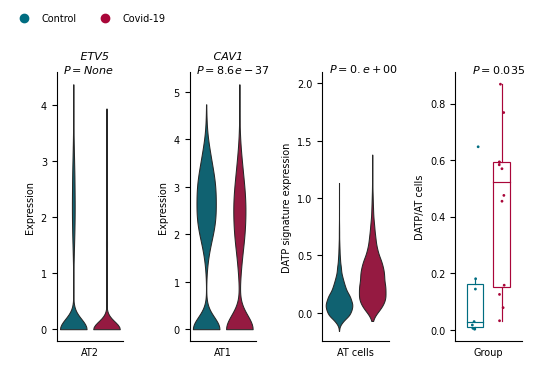

In [60]:
DATP_AT_adata = AT_adata.copy()

fig, DATP_ax = plt.subplots(nrows=1, ncols=4, figsize=(6,3.5))
plt.subplots_adjust(wspace=1)

DATP_ax[0], pvl0 = create_violin(adata=AT_adata[AT_adata.obs.cell_type=='AT2'],
                        ax=DATP_ax[0],
                        keys='ETV5',
                        xlabel='AT2',
                        ylabel='Expression',
                        value_type='gene')

DATP_ax[1], pvl1 = create_violin(adata=AT_adata[AT_adata.obs.cell_type=='AT1'],
                        ax=DATP_ax[1],
                        keys='CAV1',
                        xlabel='AT1',
                        ylabel='Expression',
                        pvalue=True,
                        value_type='gene')

DATP_ax[2], pvl2 = create_violin(adata=AT_adata,
                        ax=DATP_ax[2],
                        keys='DATP',
                        xlabel='AT cells',
                        ylabel='DATP signature expression',
                        pvalue=True,
                        value_type='obs_col')

DATP_ax[2].set_ylim(-.25,2.1)

##########################################

grouped = DATP_ratio.groupby('covid')
widths=.25
controls = grouped.get_group('Control').freq
covids = grouped.get_group('Covid-19').freq
boxprops, medianprops, whiskerprops = boxplot_properties(color_pallet().get('Control'))
DATP_ax[3].boxplot(x=controls, 
            positions=[0.8], 
            widths=widths, 
            patch_artist=True, 
            showcaps=False, 
            showfliers=False, 
            boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)
boxprops, medianprops, whiskerprops = boxplot_properties(color_pallet().get('Covid-19'))
DATP_ax[3].boxplot(x=covids, 
            positions=[1.2], 
            widths=widths, 
            patch_artist=True, 
            showcaps=False, 
            showfliers=False, 
            boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)

umap_plot_foramt(DATP_ax[3])

DATP_ax[3].set_xticks(list())
DATP_ax[3].xaxis.set_tick_params(labelbottom=False)
DATP_ax[3].set_xlabel('Group')
DATP_ax[3].set_ylabel('DATP/AT cells')
DATP_ax[3].set_xlim(.5,1.5)

sns.stripplot(data=DATP_ratio,
              x=[1 for i in range(len(DATP_ratio))], 
              y='freq', 
              hue='covid',
              size=2, 
              palette=color_pallet(),
              linewidth=0, 
              dodge=True,
              legend=False,
              jitter=True,
              ax=DATP_ax[3],
              native_scale=True)

pvl3 = format_pvalue(stats.ranksums(controls, covids).pvalue)

##########################################
    
for ax, pvalue, headline, loc in zip(DATP_ax, 
                                    [pvl0, pvl1, pvl2, pvl3], 
                                    ['ETV5', 'CAV1', '', ''], 
                                    [(-.3,4.57), (-.3,5.4), (-.3,2.1), (0.75,.9075)]):
    ax.text(x=loc[0], 
             y=loc[1], 
             s=f"     {headline}\n$P = {pvalue}$",
             fontdict=dict(fontsize=8, fontstyle='italic'))
    
plt.legend(handles=[Line2D([0], [0], marker='o', color='#006D81', label='Control', linewidth=0),
                        Line2D([0], [0], marker='o', color='#A90639', label='Covid-19', linewidth=0)], 
               loc='center', frameon=False, ncols=2, bbox_to_anchor=(-5.5, 1.2))

# fig.savefig(os.path.join(r'C:\Users\DuduB21\OneDrive\code\single_cell_analysis\restore_figures', 'AT_cells_violoin.png'), dpi=300)

plt.show()

c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


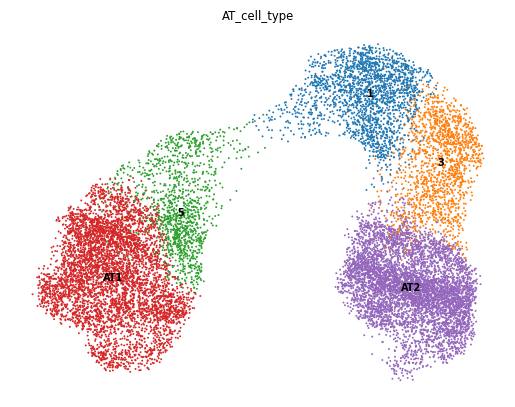

In [61]:
AT_cell_cell_types =    {
                        0:'AT2',
                        1:1,
                        2:'AT1',
                        3:3, 
                        4:'AT2',
                        5:5,
                        6:'AT2',
                        7:'AT1',
                        8:'AT1',
                        9:'AT1'
                        }
AT_adata.obs['AT_cell_type'] = AT_adata.obs.leiden_AT.map({str(k):str(v) for k, v in AT_cell_cell_types.items()})
AT_adata.obs
sc.pl.umap(AT_adata, color=['AT_cell_type'], legend_loc='on data', frameon=False)
# sc.pl.umap(AT_adata, color=['leiden_AT'], legend_loc='on data', frameon=False)

In [62]:
sc.tl.rank_genes_groups(AT_adata, groupby='AT_cell_type', method='wilcoxon')
AT_markers = sc.get.rank_genes_groups_df(AT_adata, group=['AT1', 'AT2'], pval_cutoff=0.05, log2fc_min=0.25)

ranking genes
    finished (0:00:26)


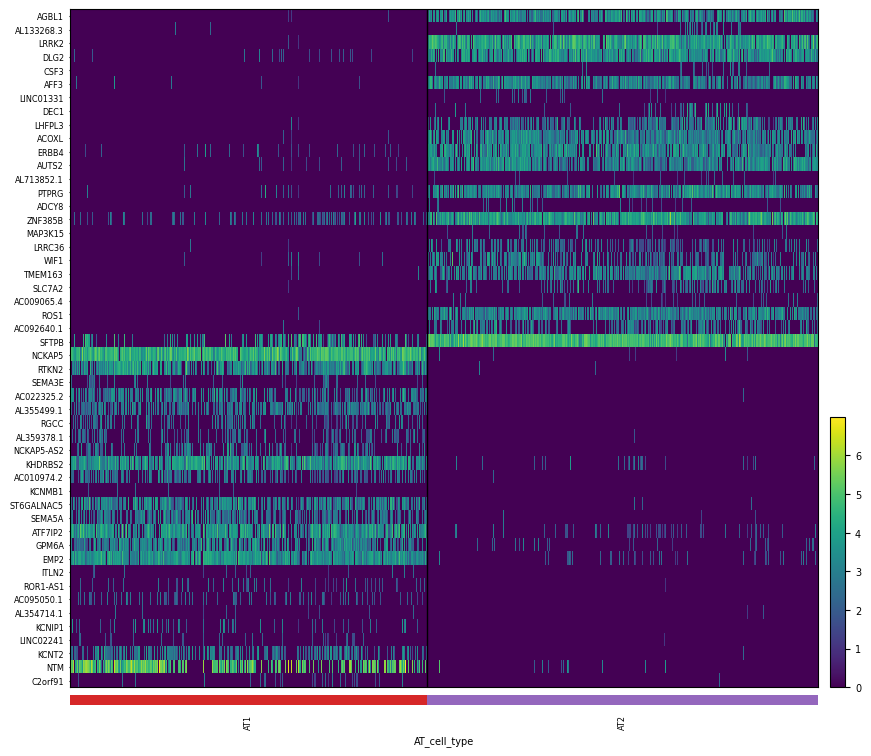

In [63]:
AT_markers.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False], inplace=True)
AT_DEG_lst = AT_markers[AT_markers.group=='AT2'].names.to_list()[:25:] + \
             AT_markers[AT_markers.group=='AT1'].names.to_list()[:25:]

sc.pl.heatmap(AT_adata[AT_adata.obs.AT_cell_type.isin(['AT1', 'AT2'])],
              var_names=AT_DEG_lst, 
              groupby='AT_cell_type',
              swap_axes=True,
              show_gene_labels=True,
              show=True)
plt.show()

In [64]:
# immune_adata = 
immune_adata = adata[adata.obs.cell_type.isin(['Monocytes/DCs', 'NK', 'T cells', 'Macrophages', 'Mast', 'Plasma cells', 'B cells'])].copy()
sc.tl.leiden(immune_adata, resolution=.75, key_added='leiden_immune') # -> leading to 9 clusters 
sc.tl.umap(immune_adata, n_components=3)
immune_umap = immune_adata.obsm['X_umap']

running Leiden clustering
    finished (0:00:18)
computing UMAP
    finished (0:00:28)


c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


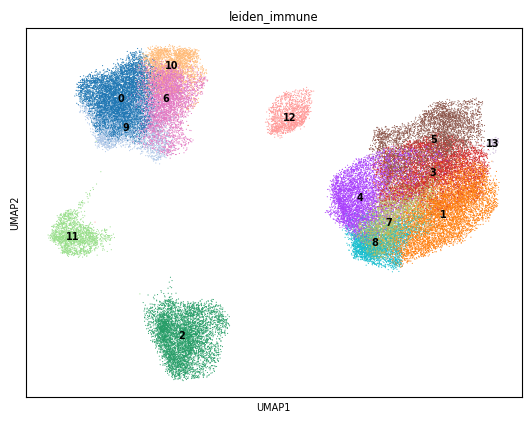

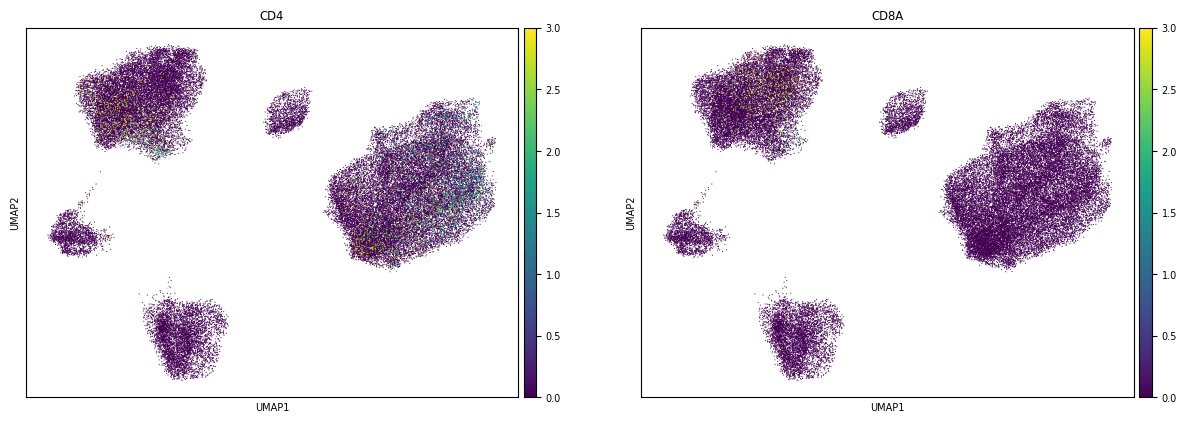

In [65]:
sc.pl.umap(immune_adata, color='leiden_immune', legend_loc='on data')
sc.pl.umap(immune_adata, color=['CD4', 'CD8A'], legend_loc='on data', vmax=3)

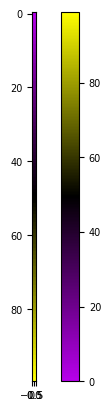

In [66]:
colors = [(183/255, 0, 235/255), (0, 0, 0), (1, 1, 0)]

# Define the positions for the colors in the color map
positions = [0, 0.5, 1]

# Create the custom color map
cmap = LinearSegmentedColormap.from_list('seurat_heatmap', list(zip(positions, colors)))

# Plot a colorbar to visualize the color map
plt.imshow([[i] for i in range(100)], cmap=cmap)
plt.colorbar()
plt.show()